In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
import time
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [53]:
preproc_files_dir = '/cluster/tufts/hugheslab/prath01/projects/MASTRE/datasets'
static_df = pd.read_csv(os.path.join(preproc_files_dir, 'static_features.csv'))
highfreq_df = pd.read_csv(os.path.join(preproc_files_dir, 'highfreq_features.csv'))
session_outcomes_df = pd.read_csv(os.path.join(preproc_files_dir, 'session_level_marksmanship_outcomes.csv'))


In [54]:
y_pre_df = session_outcomes_df[session_outcomes_df.mission_phase=='PRE'].copy().reset_index(drop=True)
y_mid_df = session_outcomes_df[session_outcomes_df.mission_phase=='MID'].copy().reset_index(drop=True)
y_post1_df = session_outcomes_df[session_outcomes_df.mission_phase=='POST1'].copy().reset_index(drop=True)
y_post2_df = session_outcomes_df[session_outcomes_df.mission_phase=='POST2'].copy().reset_index(drop=True)
y_post3_df = session_outcomes_df[session_outcomes_df.mission_phase=='POST3'].copy().reset_index(drop=True)


keep_ids = list(set(static_df.subject_uid) & 
                set(highfreq_df.subject_uid) & 
                set(y_post1_df.subject_uid) &
               set(y_post2_df.subject_uid) &
               set(y_post3_df.subject_uid))

static_df = static_df.loc[static_df.subject_uid.isin(keep_ids), :].copy().reset_index(drop=True)
highfreq_df = highfreq_df.loc[highfreq_df.subject_uid.isin(keep_ids), :].copy().reset_index(drop=True)

# define y's
y_pre_df = y_pre_df.loc[y_pre_df.subject_uid.isin(keep_ids), :].copy().reset_index(drop=True)
y_mid_df = y_mid_df.loc[y_mid_df.subject_uid.isin(keep_ids), :].copy().reset_index(drop=True)
y_post1_df = y_post1_df.loc[y_post1_df.subject_uid.isin(keep_ids), :].copy().reset_index(drop=True)
y_post2_df = y_post2_df.loc[y_post2_df.subject_uid.isin(keep_ids), :].copy().reset_index(drop=True)
y_post3_df = y_post3_df.loc[y_post3_df.subject_uid.isin(keep_ids), :].copy().reset_index(drop=True)

# define static features
non_missing_static_df = static_df.loc[:,(~static_df.isnull()).all(axis=0)].copy().reset_index(drop=True)
non_missing_static_df.replace({'yes':1, 'no':0}, inplace=True)

# define highfrequency features
shot_location_over_sessions_df = highfreq_df.groupby(['subject_uid', 'mission_phase'],
                                                     as_index=False).median()[['subject_uid', 'mission_phase',
                                                                               'shot_x_75', 'shot_y_75']]
highfreq_pre_df = shot_location_over_sessions_df.loc[shot_location_over_sessions_df.mission_phase=='PRE',
                                                        ['shot_x_75', 'shot_y_75']].reset_index(drop=True)
highfreq_mid_df = shot_location_over_sessions_df.loc[shot_location_over_sessions_df.mission_phase=='MID',
                                                        ['shot_x_75', 'shot_y_75']].reset_index(drop=True)
highfreq_post1_df = shot_location_over_sessions_df.loc[shot_location_over_sessions_df.mission_phase=='POST1',
                                                        ['shot_x_75', 'shot_y_75']].reset_index(drop=True)
highfreq_post2_df = shot_location_over_sessions_df.loc[shot_location_over_sessions_df.mission_phase=='POST2',
                                                        ['shot_x_75', 'shot_y_75']].reset_index(drop=True)

In [4]:
#------------------------------Multi Train - Test Lasso----------------------------#
def lasso_regression_multi_train_test_splits(
        X, y, n_trials, n_cv_folds,
        gridsearchvalues__alpha=np.logspace(-5, 5, 5),
        x_feature_transform='none',
        scoring_metric='mean_squared_error'):
    """ Perform nested cross-validation to train Lasso predictor given a fixed training set
    Returns
    -------
    best_regressor_per_trial : list
    perf_dict_per_trial : list
    """
    start_time_sec = time.time()

    print("Fitting Lasso with %d trials of %d-fold nested cross validation" % (
        n_trials, n_cv_folds))

    # Parameter grid to consider on each inner heldout fold
    if isinstance(gridsearchvalues__alpha, str):
        if gridsearchvalues__alpha.count("logspace"):
            gsv = gridsearchvalues__alpha.replace("logspace", "")
            gsv = gsv.replace("(", "")
            gsv = gsv.replace(")", "")
            amin, amax, anum = map(float, gsv.split(','))
            anum = int(anum)
            alpha_grid = np.logspace(amin, amax, anum).astype(np.float64)
        elif gridsearchvalues__alpha.count("linspace"):
            gsv = gridsearchvalues__alpha.replace("linspace", "")
            gsv = gsv.replace("(", "")
            gsv = gsv.replace(")", "")
            amin, amax, anum = map(float, gsv.split(','))
            anum = int(anum)
            alpha_grid = np.linspace(amin, amax, anum).astype(np.float64)
        else:
            alpha_grid = np.asarray(
                list(map(float, gridsearchvalues__alpha.split(","))),
                dtype=np.float64)
    else:
        alpha_grid = np.asarray(gridsearchvalues__alpha, dtype=np.float64)
    alpha_str = ','.join(['%.3g' % a for a in alpha_grid[:3]])
    if alpha_grid.size > 5:
        alpha_str += ',' + '...'
    if alpha_grid.size > 3:
        M = np.maximum(3, alpha_grid.size - 2)
        alpha_str += ',' + ','.join(['%.3g' % a for a in alpha_grid[M:]])
    print("Selecting parameter 'alpha' based on grid search over %d param values:\n%s" % (
        alpha_grid.size, alpha_str))
    param_grid = [{'regressor__alpha': alpha_grid}]
    
    # Arrays to store scores
    best_regressors = [None for _ in range(n_trials)]
    outer_perf_dict_list = [None for _ in range(n_trials)]
    inner_perf_df_list = [None for _ in range(n_trials)]
    
    # Loop for each trial
    for i in range(n_trials):
      
        # Perform OUTER train-test split
        # If we use a test size of 1/(K+1)
        # Then we'll get heldout folds of the same size as the inner heldout folds with K-fold CV
        # Why?
        # Outer fold takes 1/(K+1) of N examples
        # Inner fold takes 1/K of ( K/(K+1) * N ) examples = 1/(K+1) * N
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1.0/(1+n_cv_folds)), random_state=i)  

        # create a cv splitter object 
        inner_cv_splitter = KFold(n_splits=n_cv_folds, shuffle=True, random_state=i)
        
        # STEP 1 in pipeline: 
        step_list = list()
        if x_feature_transform.startswith('standardize'):
            ## Scale the input features to have zero mean/unit variance
            scaler_x = StandardScaler()
            step_list.append(('standardize', scaler_x))
        elif x_feature_transform == 'scale_0_to_1':
            ## Scale the input features to have min zero and max one
            scaler_x = MaxAbsScaler()
            step_list.append(('scale_0_to_1', scaler_x))
        elif x_feature_transform == 'none':
            pass
        else:
            raise ValueError("Unrecognized value: 'x_feature_transform'=%s" % x_feature_transform)
        
        # STEP 2 in pipeline: Define the predictor from input to output
        step_list.append(('regressor', Lasso(max_iter=1000000, tol=0.001, selection='cyclic')))

        ## Create Pipeline regressor as composition of steps
        prediction_pipeline = Pipeline(step_list)

        ## Prepare for n-fold cross validation
        if scoring_metric == 'mean_absolute_error':
            scoring = 'neg_mean_absolute_error'
            baseline_func = np.median
        elif scoring_metric == 'mean_squared_error':
            scoring = 'neg_mean_squared_error'
            baseline_func = np.mean
        else:
            raise ValueError("Unrecognized value: 'scoring_metric'=%s" % scoring_metric)

        regressor_with_grid_search = GridSearchCV(
                prediction_pipeline, param_grid,
                cv=inner_cv_splitter,
                scoring=scoring,
                return_train_score=True,
                iid=False, refit=True)
        regressor_with_grid_search.fit(X_train, y_train)

        best_i = regressor_with_grid_search.best_index_
        inner_cv_df = pd.DataFrame(regressor_with_grid_search.cv_results_)
        perf_at_best_df = inner_cv_df.iloc[best_i:(best_i+1)].copy()

        best_regressors[i] = regressor_with_grid_search.best_estimator_
        outer_train_score = regressor_with_grid_search.score(X_train, y_train)
        outer_test_score = regressor_with_grid_search.score(X_test, y_test)
        cur_perf = OrderedDict()
        cur_perf['trial_id'] = i
        for mname, metric_func in [
                ('mse', mean_squared_error),
                ('mae', mean_absolute_error)
                ]:
            yhat_train = best_regressors[i].predict(X_train)
            yhat_test = best_regressors[i].predict(X_test)
            cur_perf['train_%s' % mname] = metric_func(y_train, yhat_train)
            cur_perf['test_%s' % mname] = metric_func(y_test, yhat_test)
        cur_perf['train_size'] = y_train.size
        cur_perf['test_size'] = y_test.size

        cur_perf['outer_train_score'] = -1 * outer_train_score
        cur_perf['outer_test_score'] = -1 * outer_test_score
        cur_perf['inner_mean_train_score'] = -1 * perf_at_best_df['mean_train_score'].values[0]
        cur_perf['inner_mean_test_score'] = -1 * perf_at_best_df['mean_test_score'].values[0]
        tr_vals = np.zeros(n_cv_folds)
        te_vals = np.zeros(n_cv_folds)
        for ss in range(n_cv_folds):
            key = 'split%d' % ss
            tr_vals[ss] = -1 * perf_at_best_df['%s_train_score' % key].values[0]
            te_vals[ss] = -1 * perf_at_best_df['%s_test_score' % key].values[0]
            cur_perf['inner_%s_train_score' % key] = tr_vals[ss]
            cur_perf['inner_%s_test_score' % key] = te_vals[ss]
        for fname, func in [('min', np.min), ('max', np.max)]:
            cur_perf['inner_%s_train_score' % fname] = func(tr_vals)
            cur_perf['inner_%s_test_score' % fname] = func(te_vals)
        outer_perf_dict_list[i] = cur_perf

        cur_perf['outer_model_bias'] = best_regressors[i]['regressor'].intercept_
        cur_perf['outer_model_num_nonzero_coef'] = np.sum(np.abs(best_regressors[i]['regressor'].coef_) > 1e-8)

        for key in sorted(regressor_with_grid_search.best_params_.keys()):
            cur_perf['outer_model_best_param__%s' % key] = regressor_with_grid_search.best_params_[key]

        outer_perf_dict_list[i] = cur_perf
        inner_perf_df_list[i] = inner_cv_df

        print("completed trial %3d/%d after %8.0f sec | tr score %8.3f | te score %8.3f | nnz %6d" % (
            i + 1, n_trials, time.time() - start_time_sec, 
            cur_perf['outer_train_score'],
            cur_perf['outer_test_score'],
            cur_perf['outer_model_num_nonzero_coef'],
            ))

    outer_perf_df = pd.DataFrame(outer_perf_dict_list)
    return best_regressors, outer_perf_df, inner_perf_df_list

## predict post3 with past y factors

This includes 4 scenarios:
- predicting performance on post3 with only pre-mission performance
- predicting performance on post3 with only pre-mission, post1 mission
- predicting performance on post3 with only pre-mission, post1 mission, post2 mission
- predicting performance on post3 with only pre-mission, post1 mission, post2 mission and X-factors

In [87]:
n_trials = 20
n_cv_folds = 10
row_df_list = list()
for y_factor in ['lethality', 'mobility', 'stability']:
    X_pre = np.asarray(y_pre_df[y_factor], dtype=np.float64).reshape(-1,1)
    X_pre_mid = np.asarray([y_pre_df[y_factor], y_mid_df[y_factor]], dtype=np.float64).T
    X_pre_mid_post1 = np.asarray([y_pre_df[y_factor], y_mid_df[y_factor], y_post1_df[y_factor]], dtype=np.float64).T
    X_pre_mid_post1_post2 = np.asarray([y_pre_df[y_factor], y_mid_df[y_factor], 
                                        y_post1_df[y_factor], y_post2_df[y_factor]], dtype=np.float64).T
    X_static_pre_mid_post1_post2 = np.asarray(np.concatenate((non_missing_static_df.values, 
                                                              y_pre_df[y_factor].values.reshape(-1,1),
                                                              y_mid_df[y_factor].values.reshape(-1,1),
                                                              y_post1_df[y_factor].values.reshape(-1,1), 
                                                              y_post2_df[y_factor].values.reshape(-1,1)), axis=1), 
                                              dtype=np.float64)
    
    X_highfreq_pre_mid_post1_post2 = np.asarray(np.concatenate((highfreq_pre_df.values,
                                                                highfreq_mid_df.values,
                                                                highfreq_post1_df.values,
                                                                highfreq_post2_df.values,
                                                              y_pre_df[y_factor].values.reshape(-1,1),
                                                              y_mid_df[y_factor].values.reshape(-1,1),
                                                              y_post1_df[y_factor].values.reshape(-1,1), 
                                                              y_post2_df[y_factor].values.reshape(-1,1)), axis=1), 
                                              dtype=np.float64)
    
    y_out = np.asarray(y_post3_df[y_factor], dtype=np.float64)
    perc_vals = [5, 50, 95]

    
    for X,y,feature_nickname in [(X_pre, y_out, 'pre'), 
                                 (X_pre_mid, y_out, 'pre+mid'),
                                 (X_pre_mid_post1, y_out, 'pre+mid+post1'), 
                                 (X_pre_mid_post1_post2, y_out, 'pre+mid+post1+post2'), 
                                 (X_static_pre_mid_post1_post2, y_out, 'static+pre+mid+post1+post2'),
#                                  (X_highfreq_pre_mid_post1_post2, y_out, 'highfreq+pre+mid+post1+post2')
                                ]:
        print('Predicting %s with %s as predictors'%(y_factor, feature_nickname))
        best_regressors, outer_perf_df, inner_perf_df_list = lasso_regression_multi_train_test_splits(X, y, 
                                                                                                      n_trials, n_cv_folds,
                                                                                                      gridsearchvalues__alpha=np.logspace(-12, 6, 37),
                                                                                                      x_feature_transform='standardize',
                                                                                                      scoring_metric='mean_absolute_error')

        for perc in perc_vals:
            row_df = pd.DataFrame(
                [np.percentile(outer_perf_df.values[:, 1:], perc, axis=0)],
                columns=outer_perf_df.columns[1:])
            row_df.insert(0, 'y_column', y_factor)
            row_df.insert(1, 'x_feature_nickname', feature_nickname)
            row_df.insert(2, 'n_features', X.shape[1])
            row_df.insert(3, 'percentile_across_trials', perc)
            row_df_list.append(row_df)
summary_perf_df = pd.concat(row_df_list, ignore_index=True)
    

Predicting lethality with pre as predictors
Fitting Lasso with 20 trials of 10-fold nested cross validation
Selecting parameter 'alpha' based on grid search over 37 param values:
1e-12,3.16e-12,1e-11,...,3.16e+05,1e+06
completed trial   1/20 after        1 sec | tr score   27.566 | te score   46.429 | nnz      0
completed trial   2/20 after        2 sec | tr score   31.586 | te score   18.345 | nnz      0
completed trial   3/20 after        3 sec | tr score   29.241 | te score   36.130 | nnz      0
completed trial   4/20 after        4 sec | tr score   29.130 | te score   34.629 | nnz      0
completed trial   5/20 after        6 sec | tr score   31.890 | te score   16.326 | nnz      0
completed trial   6/20 after        7 sec | tr score   30.916 | te score   23.310 | nnz      0
completed trial   7/20 after        8 sec | tr score   30.409 | te score   30.258 | nnz      0
completed trial   8/20 after        9 sec | tr score   28.617 | te score   39.217 | nnz      0
completed trial   9/2

completed trial  18/20 after       21 sec | tr score   27.219 | te score   13.085 | nnz      1
completed trial  19/20 after       22 sec | tr score   25.268 | te score   18.202 | nnz      1
completed trial  20/20 after       23 sec | tr score   25.437 | te score   17.141 | nnz      1
Predicting lethality with static+pre+mid+post1+post2 as predictors
Fitting Lasso with 20 trials of 10-fold nested cross validation
Selecting parameter 'alpha' based on grid search over 37 param values:
1e-12,3.16e-12,1e-11,...,3.16e+05,1e+06
completed trial   1/20 after        2 sec | tr score   25.084 | te score   40.112 | nnz      1
completed trial   2/20 after        4 sec | tr score   24.488 | te score   24.954 | nnz      2
completed trial   3/20 after        5 sec | tr score   26.993 | te score   24.356 | nnz      1
completed trial   4/20 after        7 sec | tr score   24.847 | te score   28.274 | nnz      3
completed trial   5/20 after        9 sec | tr score   27.795 | te score   11.879 | nnz      

completed trial  15/20 after       17 sec | tr score    0.137 | te score    0.218 | nnz      2
completed trial  16/20 after       18 sec | tr score    0.156 | te score    0.130 | nnz      3
completed trial  17/20 after       20 sec | tr score    0.137 | te score    0.265 | nnz      3
completed trial  18/20 after       21 sec | tr score    0.153 | te score    0.145 | nnz      3
completed trial  19/20 after       22 sec | tr score    0.157 | te score    0.098 | nnz      3
completed trial  20/20 after       23 sec | tr score    0.139 | te score    0.218 | nnz      3
Predicting mobility with pre+mid+post1+post2 as predictors
Fitting Lasso with 20 trials of 10-fold nested cross validation
Selecting parameter 'alpha' based on grid search over 37 param values:
1e-12,3.16e-12,1e-11,...,3.16e+05,1e+06
completed trial   1/20 after        1 sec | tr score    0.125 | te score    0.171 | nnz      4
completed trial   2/20 after        2 sec | tr score    0.116 | te score    0.269 | nnz      3
comple

/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18178060.349909306, tolerance: 3640709.047393581
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11842235.694561481, tolerance: 3911352.703753089
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11434440.022490025, tolerance: 3640709.047393581
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3

completed trial   1/20 after        3 sec | tr score 7470.070 | te score 15829.668 | nnz      0


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39300275.589224815, tolerance: 5989637.600868026
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19680827.38776779, tolerance: 5134289.809062208
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27839193.188617706, tolerance: 5857592.365083848
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial   2/20 after        8 sec | tr score 8523.106 | te score 6254.889 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1006714658.6648376, tolerance: 5314840.615667808
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260889578.51754045, tolerance: 5053423.35325343
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187304557.77798843, tolerance: 4942268.789034736
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial   3/20 after       13 sec | tr score 7925.297 | te score 11245.173 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86784435.60413074, tolerance: 5956803.553420818
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100229571.6553564, tolerance: 3819186.305570624
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141534692.07890224, tolerance: 5334039.215684975
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial   4/20 after       16 sec | tr score 8922.572 | te score 3904.712 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84648153.22068024, tolerance: 5950927.2020908585
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 409731338.34501696, tolerance: 5602685.3588771075
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130429966.08403492, tolerance: 5950927.2020908585
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/pytho

completed trial   5/20 after       20 sec | tr score 8445.066 | te score 7358.107 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20827329.321470737, tolerance: 4231966.720177575
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158549543.94048977, tolerance: 4521627.531800256
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24656148.46122074, tolerance: 5061559.173145756
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial   6/20 after       23 sec | tr score 8003.540 | te score 11064.891 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132858719.9894371, tolerance: 5764952.98422884
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44064215.98135233, tolerance: 4982791.718949523
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121925901.18229485, tolerance: 3822142.3728052313
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial   7/20 after       28 sec | tr score 8405.308 | te score 8778.598 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 642721900.2749219, tolerance: 6047277.254872908
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27831193.429758072, tolerance: 6003215.70568033
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 640738751.2402167, tolerance: 5980205.879051107
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/

completed trial   8/20 after       33 sec | tr score 8434.565 | te score 5795.576 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 367638060.5435648, tolerance: 5156916.567105718
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136879243.80710602, tolerance: 5099501.782669748
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 639300560.7178869, tolerance: 5207096.96663152
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/

completed trial   9/20 after       41 sec | tr score 8051.372 | te score 9734.052 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20054084.651803493, tolerance: 4411720.944987731
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 395596243.48525333, tolerance: 4852417.045970724
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33384285.213454723, tolerance: 4948399.840559189
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3

completed trial  10/20 after       45 sec | tr score 7717.529 | te score 12012.858 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20788302.21116972, tolerance: 4340959.107168399
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 876139732.4542766, tolerance: 5942227.738061206
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28101082.10090351, tolerance: 5811564.862260113
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/

completed trial  11/20 after       50 sec | tr score 8750.231 | te score 4553.039 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 462547589.121891, tolerance: 5049596.2660561
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9082072.256084442, tolerance: 5870938.250932575
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79356013.59528828, tolerance: 5598134.543186505
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/sit

completed trial  12/20 after       55 sec | tr score 8369.966 | te score 8876.861 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20396257.86532545, tolerance: 4484073.137611125
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27194759.48602867, tolerance: 5969831.897584797
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149440322.9979396, tolerance: 5905959.995745019
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/

completed trial  13/20 after       60 sec | tr score 8670.309 | te score 6175.576 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 148099533.02165365, tolerance: 5576136.632670025
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16502103.173268318, tolerance: 5558863.86737902
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64969900.46674919, tolerance: 4653385.583935299
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial  14/20 after       68 sec | tr score 8356.267 | te score 8338.724 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154677907.34628725, tolerance: 5086605.149327441
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154597875.50540352, tolerance: 5750997.456979165
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196410583.64457893, tolerance: 5926412.358435918
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3

completed trial  15/20 after       73 sec | tr score 8542.617 | te score 5735.910 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189808124.56033564, tolerance: 4769504.736584299
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73791351.37810278, tolerance: 5011529.799837889
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7989506.898507118, tolerance: 4765986.562998331
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial  16/20 after       78 sec | tr score 7925.931 | te score 12033.275 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81300399.55160618, tolerance: 5672759.355750792
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 152347719.8539858, tolerance: 5716283.833434389
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 683907638.7477803, tolerance: 5835466.223106697
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/

completed trial  17/20 after       82 sec | tr score 8603.916 | te score 6590.437 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27553627.429714203, tolerance: 5869247.0514565
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81063841.95115948, tolerance: 5764215.945679699
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17580951.736807823, tolerance: 5486793.40845763
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/s

completed trial  18/20 after       85 sec | tr score 8523.880 | te score 8318.345 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217544174.61622238, tolerance: 5471701.788631123
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24989478.98671627, tolerance: 5229149.5926524885
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30480898.222867012, tolerance: 5316471.3700172305
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python

completed trial  19/20 after       90 sec | tr score 8002.922 | te score 9211.325 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 236429549.80888748, tolerance: 5887562.3647219315
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 806000004.625299, tolerance: 5898815.730657341
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 533290488.4369564, tolerance: 5860113.485215457
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial  20/20 after       95 sec | tr score 8831.895 | te score 4846.054 | nnz      1
Predicting stability with pre+mid as predictors
Fitting Lasso with 20 trials of 10-fold nested cross validation
Selecting parameter 'alpha' based on grid search over 37 param values:
1e-12,3.16e-12,1e-11,...,3.16e+05,1e+06


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126920726.88026357, tolerance: 3644550.7173285196
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78142543.56295943, tolerance: 3591220.099977218
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184596960.06570387, tolerance: 3519381.393611472
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3

completed trial   1/20 after        5 sec | tr score 6535.894 | te score 11762.024 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 688972509.4424276, tolerance: 5745662.870398623
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 577333899.1555703, tolerance: 5989637.600868026
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 143282926.9604404, tolerance: 5748397.299080475
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/

completed trial   2/20 after       12 sec | tr score 6698.487 | te score 7088.496 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77556080.9442153, tolerance: 4311947.709493556
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218020995.71688724, tolerance: 5050875.465300291
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323477587.7463715, tolerance: 5314840.615667808
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/

completed trial   3/20 after       20 sec | tr score 6421.298 | te score 9952.418 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107860804.54250526, tolerance: 6105623.314759675
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 251680256.20089793, tolerance: 5213689.715960769
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 152972749.65437913, tolerance: 3819186.305570624
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3

completed trial   4/20 after       23 sec | tr score 7320.365 | te score 2337.614 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 943493193.0982461, tolerance: 5950927.2020908585
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361214732.76726913, tolerance: 5715798.418877672
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252434494.93250751, tolerance: 5090748.517996832
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3

completed trial   5/20 after       30 sec | tr score 7359.598 | te score 2609.013 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1102457817.157948, tolerance: 4828490.57093789
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 751019821.8334782, tolerance: 5138120.227600468
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127915682.00695944, tolerance: 4834025.387766265
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/

completed trial   6/20 after       44 sec | tr score 6678.816 | te score 8273.098 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 626887318.939716, tolerance: 5444913.1232266985
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 300139378.5453689, tolerance: 5764952.98422884
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21114088.288008213, tolerance: 5665834.54609753
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/s

completed trial   7/20 after       51 sec | tr score 6659.495 | te score 8617.897 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275839266.0113096, tolerance: 6047277.254872908
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 648873675.1969538, tolerance: 5861179.3346349755
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471838356.15999603, tolerance: 5424202.760894281
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial   8/20 after       60 sec | tr score 6518.934 | te score 8319.994 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 235324052.59514236, tolerance: 5099501.782669748
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 481389062.2117715, tolerance: 5207096.96663152
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49246403.48006773, tolerance: 4937046.755173574
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/

completed trial   9/20 after       66 sec | tr score 6755.242 | te score 7610.990 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14435202.394534588, tolerance: 4925585.711928341
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 746404558.8258027, tolerance: 4852417.045970724
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 212111235.46101952, tolerance: 5062284.879642519
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial  10/20 after       73 sec | tr score 6156.534 | te score 11359.919 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 596866242.6690392, tolerance: 5915270.4862425
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 501520022.1281822, tolerance: 3825948.241008775
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 559380794.4151647, tolerance: 5942227.738061206
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/si

completed trial  11/20 after       79 sec | tr score 6758.195 | te score 7626.560 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 689455521.365242, tolerance: 5719042.894967942
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74103942.29319382, tolerance: 3830351.740303476
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128671566.86031866, tolerance: 5474997.785369939
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/

completed trial  12/20 after       87 sec | tr score 6673.432 | te score 7934.194 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222177032.96849442, tolerance: 4484073.137611125
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 840968878.0561631, tolerance: 5969831.897584797
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 903827539.2471792, tolerance: 5905959.995745019
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial  13/20 after       94 sec | tr score 7074.265 | te score 4972.203 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 331535251.28544784, tolerance: 5577287.723984906
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1015013665.2117912, tolerance: 5576136.632670025
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91564399.39576578, tolerance: 5453476.877062963
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial  14/20 after      105 sec | tr score 6528.776 | te score 8940.387 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 714586901.0467261, tolerance: 5086605.149327441
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 378234796.0970762, tolerance: 4784659.3940758705
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327229316.80427647, tolerance: 3867228.0613654247
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3

completed trial  15/20 after      115 sec | tr score 6475.236 | te score 9164.901 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158922312.43657017, tolerance: 4952840.55619052
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 565648982.4223778, tolerance: 4848708.5322798975
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17400489.305384636, tolerance: 4956631.531508158
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial  16/20 after      119 sec | tr score 6664.593 | te score 8762.875 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 821309650.1484694, tolerance: 5930294.032108501
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 664719005.3138583, tolerance: 5672759.355750792
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153568072.19135904, tolerance: 5716283.833434389
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial  17/20 after      124 sec | tr score 7070.467 | te score 5384.652 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 512895579.49314237, tolerance: 5741659.746176842
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 959298391.640756, tolerance: 5869247.0514565
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 674486954.2556229, tolerance: 5909040.2983179735
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/s

completed trial  18/20 after      132 sec | tr score 6898.136 | te score 6487.128 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 529607427.7651007, tolerance: 5316471.3700172305
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1044764371.6560487, tolerance: 5471701.788631123
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42900254.22850132, tolerance: 4464063.987262491
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial  19/20 after      138 sec | tr score 6771.756 | te score 6469.961 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 451990418.261888, tolerance: 5887562.3647219315
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 396301752.56626844, tolerance: 5898815.730657341
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 725469605.5721428, tolerance: 5816846.385828101
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial  20/20 after      145 sec | tr score 6714.649 | te score 7658.819 | nnz      1
Predicting stability with pre+mid+post1 as predictors
Fitting Lasso with 20 trials of 10-fold nested cross validation
Selecting parameter 'alpha' based on grid search over 37 param values:
1e-12,3.16e-12,1e-11,...,3.16e+05,1e+06


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33086323.45652175, tolerance: 3644550.7173285196
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38150635.27383852, tolerance: 3591220.099977218
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97768084.51070261, tolerance: 3519381.393611472
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial   1/20 after        8 sec | tr score 6498.932 | te score 12603.473 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340173059.9761667, tolerance: 5745662.870398623
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46636712.97168636, tolerance: 5989637.600868026
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 494377002.18920255, tolerance: 3763845.254943397
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial   2/20 after       16 sec | tr score 6713.776 | te score 7468.200 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90065656.69919586, tolerance: 5123812.094686089
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 856205406.148078, tolerance: 5314840.615667808
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 595703125.4804548, tolerance: 5039701.487618751
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/s

completed trial   3/20 after       28 sec | tr score 6426.927 | te score 9956.258 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106169782.69619179, tolerance: 6105623.314759675
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364234939.44129324, tolerance: 6158389.232119471
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62549746.88084173, tolerance: 6052646.099851105
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial   4/20 after       35 sec | tr score 7331.527 | te score 2371.325 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114209178.46793127, tolerance: 5715798.418877672
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92775797.54010725, tolerance: 5087997.3592283195
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161019022.7204051, tolerance: 5889512.296759988
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial   5/20 after       45 sec | tr score 7295.008 | te score 3311.545 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1006030208.0837919, tolerance: 4828490.57093789
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 426383359.81226325, tolerance: 5138120.227600468
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14995854.148344994, tolerance: 4834025.387766265
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial   6/20 after       58 sec | tr score 6679.022 | te score 8260.545 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 744305971.4889044, tolerance: 5444913.1232266985
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15405738.69547987, tolerance: 5502960.066561791
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 619885722.8262091, tolerance: 5041762.320959807
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial   7/20 after       68 sec | tr score 6657.901 | te score 8757.724 | nnz      3


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144619174.52238464, tolerance: 6047277.254872908
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 680860096.721715, tolerance: 5861179.3346349755
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36542637.46536422, tolerance: 4127225.6787186223
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial   8/20 after       81 sec | tr score 6454.922 | te score 9475.713 | nnz      3


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82687843.65125322, tolerance: 5156916.567105718
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 853200206.1409191, tolerance: 5207096.96663152
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292303332.52320385, tolerance: 5139160.009973341
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/

completed trial   9/20 after       91 sec | tr score 6755.242 | te score 7610.990 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 510941003.6445855, tolerance: 5130960.768167507
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221509977.35981274, tolerance: 4925585.711928341
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10531332.497653246, tolerance: 3002684.8445403078
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3

completed trial  10/20 after      101 sec | tr score 6162.777 | te score 11247.662 | nnz      3


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 433299847.9401195, tolerance: 5915270.4862425
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 692595737.9088665, tolerance: 5879275.314628291
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343140985.8259678, tolerance: 5942227.738061206
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/si

completed trial  11/20 after      110 sec | tr score 6746.048 | te score 7126.322 | nnz      3


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 775987670.4988024, tolerance: 5597209.688036519
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543288491.98967, tolerance: 5520247.738032019
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 527455355.2939532, tolerance: 5598134.543186505
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/si

completed trial  12/20 after      119 sec | tr score 6704.638 | te score 7878.253 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 524425832.2512431, tolerance: 4484073.137611125
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52877162.359939575, tolerance: 5969831.897584797
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 591462782.8190339, tolerance: 5905959.995745019
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial  13/20 after      129 sec | tr score 7475.263 | te score 4808.653 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 233878080.69021678, tolerance: 5577287.723984906
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 544875450.3335497, tolerance: 5576136.632670025
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47467417.4234705, tolerance: 5453476.877062963
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/

completed trial  14/20 after      141 sec | tr score 6488.793 | te score 9482.331 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 691513596.8819957, tolerance: 5086605.149327441
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215317487.0135336, tolerance: 4784659.3940758705
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 270246842.88234305, tolerance: 5926412.358435918
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial  15/20 after      150 sec | tr score 6471.937 | te score 9163.996 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49850695.054154396, tolerance: 5011529.799837889
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 403328821.8417008, tolerance: 4765986.562998331
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48356871.45478296, tolerance: 4952840.55619052
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/

completed trial  16/20 after      158 sec | tr score 6664.593 | te score 8762.875 | nnz      1


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369694830.5800128, tolerance: 5930294.032108501
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145866848.22018766, tolerance: 5672759.355750792
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354889684.1332493, tolerance: 5716283.833434389
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial  17/20 after      167 sec | tr score 7079.517 | te score 5370.655 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 876928403.1128116, tolerance: 5741659.746176842
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 623141550.6292276, tolerance: 5869247.0514565
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50748730.93843603, tolerance: 5479202.854056057
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/si

completed trial  18/20 after      176 sec | tr score 6910.503 | te score 6456.108 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 442081876.0383134, tolerance: 5316471.3700172305
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150869545.80365658, tolerance: 5471701.788631123
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139090724.52455997, tolerance: 5210329.698851968
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3

completed trial  19/20 after      186 sec | tr score 6815.106 | te score 6248.566 | nnz      3


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 380298759.59441614, tolerance: 5887562.3647219315
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325428180.9178827, tolerance: 5898815.730657341
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 669536257.8897531, tolerance: 5816846.385828101
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial  20/20 after      197 sec | tr score 6714.649 | te score 7658.819 | nnz      1
Predicting stability with pre+mid+post1+post2 as predictors
Fitting Lasso with 20 trials of 10-fold nested cross validation
Selecting parameter 'alpha' based on grid search over 37 param values:
1e-12,3.16e-12,1e-11,...,3.16e+05,1e+06


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59960890.71137929, tolerance: 3644550.7173285196
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 273933019.2672889, tolerance: 3591220.099977218
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32072439.36989379, tolerance: 3519381.393611472
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial   1/20 after       12 sec | tr score 6286.378 | te score 11242.135 | nnz      3


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 587904701.9234613, tolerance: 5745662.870398623
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79020278.95021272, tolerance: 5989637.600868026
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 272828092.92640257, tolerance: 3763845.254943397
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial   2/20 after       25 sec | tr score 6304.234 | te score 6740.931 | nnz      3


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80970627.84356403, tolerance: 5123812.094686089
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 342457332.0681257, tolerance: 5050875.465300291
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79551358.14341426, tolerance: 5314840.615667808
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/

completed trial   3/20 after       37 sec | tr score 6145.874 | te score 9395.744 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136935035.55736923, tolerance: 6158389.232119471
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420481989.77109194, tolerance: 6052646.099851105
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137645342.22933292, tolerance: 5956803.553420818
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3

completed trial   4/20 after       48 sec | tr score 7118.870 | te score 1889.716 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220751845.82387257, tolerance: 5950927.2020908585
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137504432.50423622, tolerance: 5087997.3592283195
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136667137.44891262, tolerance: 5889512.296759988
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/pytho

completed trial   5/20 after       60 sec | tr score 6835.588 | te score 4029.499 | nnz      3


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 622401850.5210817, tolerance: 4828490.57093789
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 274906591.1534252, tolerance: 5138120.227600468
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189502562.2330742, tolerance: 4834025.387766265
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/s

completed trial   6/20 after       73 sec | tr score 6433.570 | te score 7099.961 | nnz      3


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361548231.92385864, tolerance: 5444913.1232266985
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 341854749.6693593, tolerance: 5764952.98422884
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182256477.91299534, tolerance: 5665834.54609753
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial   7/20 after       85 sec | tr score 6164.673 | te score 11034.991 | nnz      3


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168857304.80199528, tolerance: 6047277.254872908
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 376556518.2345574, tolerance: 5861179.3346349755
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14177891.758489132, tolerance: 5424202.760894281
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3

completed trial   8/20 after       97 sec | tr score 6303.593 | te score 7558.349 | nnz      3


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302018142.45391107, tolerance: 5099501.782669748
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175740720.0016806, tolerance: 5187850.742790975
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 470148960.6897656, tolerance: 5207096.96663152
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/

completed trial   9/20 after      109 sec | tr score 6599.102 | te score 6157.625 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38091007.81254101, tolerance: 5130960.768167507
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13283675.080235004, tolerance: 3002684.8445403078
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 442711237.1931319, tolerance: 4852417.045970724
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial  10/20 after      119 sec | tr score 6100.549 | te score 9111.735 | nnz      3


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 441487976.3460281, tolerance: 5915270.4862425
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 769418631.4940393, tolerance: 5879275.314628291
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 657309190.967829, tolerance: 5942227.738061206
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/sit

completed trial  11/20 after      129 sec | tr score 6385.781 | te score 6455.466 | nnz      3


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118529036.80304122, tolerance: 5719042.894967942
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76681351.00913572, tolerance: 5474997.785369939
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338081290.37556744, tolerance: 5012099.596747825
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial  12/20 after      144 sec | tr score 6299.835 | te score 8494.109 | nnz      3


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 484781185.24595714, tolerance: 4484073.137611125
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 296335467.57201004, tolerance: 5969831.897584797
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 838690367.5719509, tolerance: 5905959.995745019
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial  13/20 after      158 sec | tr score 6653.103 | te score 5132.429 | nnz      3


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183981721.60493755, tolerance: 5576136.632670025
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82250091.34031606, tolerance: 5558863.86737902
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 390474146.8666196, tolerance: 4653385.583935299
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/

completed trial  14/20 after      172 sec | tr score 6231.840 | te score 11878.577 | nnz      4


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218294752.47126842, tolerance: 5086605.149327441
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106405673.64071465, tolerance: 4784659.3940758705
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 390932804.9662056, tolerance: 3867228.0613654247
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python

completed trial  15/20 after      189 sec | tr score 6207.276 | te score 8687.633 | nnz      4


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107748349.81211185, tolerance: 4765986.562998331
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 232806035.27256465, tolerance: 4952840.55619052
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278672414.7863264, tolerance: 5001673.031528997
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial  16/20 after      203 sec | tr score 6405.043 | te score 7608.184 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205211010.53648973, tolerance: 5672759.355750792
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 461013248.6552894, tolerance: 5716283.833434389
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 371183866.05649805, tolerance: 5648832.943242491
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial  17/20 after      220 sec | tr score 6849.310 | te score 3914.629 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170719214.19700527, tolerance: 5486793.40845763
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257845836.00963163, tolerance: 5847800.184064292
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 697502807.7817501, tolerance: 5741659.746176842
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial  18/20 after      237 sec | tr score 6522.816 | te score 6764.763 | nnz      3


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 414861322.184324, tolerance: 5316471.3700172305
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 540645245.3429554, tolerance: 5471701.788631123
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19539817.840539217, tolerance: 4464063.987262491
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial  19/20 after      244 sec | tr score 6388.610 | te score 7145.140 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 195849206.6186149, tolerance: 5887562.3647219315
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313772742.6762444, tolerance: 5898815.730657341
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63020529.3735795, tolerance: 5816846.385828101
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/

completed trial  20/20 after      260 sec | tr score 6455.562 | te score 6797.513 | nnz      2
Predicting stability with static+pre+mid+post1+post2 as predictors
Fitting Lasso with 20 trials of 10-fold nested cross validation
Selecting parameter 'alpha' based on grid search over 37 param values:
1e-12,3.16e-12,1e-11,...,3.16e+05,1e+06


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91167795.5045445, tolerance: 3644550.7173285196
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53302933.7883592, tolerance: 3591220.099977218
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99024794.4056034, tolerance: 3911352.703753089
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/si

completed trial   1/20 after       41 sec | tr score 6922.868 | te score 14222.601 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89015174.89046599, tolerance: 5745662.870398623
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 129504918.09690759, tolerance: 3763845.254943397
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106723960.72647542, tolerance: 5895801.390408101
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial   2/20 after       77 sec | tr score 4565.885 | te score 9044.094 | nnz     11


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110203751.40050453, tolerance: 4311947.709493556
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84839246.70925537, tolerance: 5123812.094686089
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 146079415.72521043, tolerance: 5050875.465300291
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial   3/20 after      125 sec | tr score 5117.669 | te score 8078.374 | nnz      9


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59830100.25384307, tolerance: 6052646.099851105
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106833917.44470558, tolerance: 5956803.553420818
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61268750.67089233, tolerance: 3819186.305570624
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial   4/20 after      154 sec | tr score 4925.488 | te score 6522.038 | nnz     11


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125133066.87609467, tolerance: 5950927.2020908585
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100857717.80179942, tolerance: 5087997.3592283195
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 102828833.3159764, tolerance: 5090748.517996832
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python

completed trial   5/20 after      200 sec | tr score 7362.322 | te score 4178.440 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165644800.5310188, tolerance: 5056598.404391342
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151710357.339583, tolerance: 4828490.57093789
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59989659.152671516, tolerance: 5138120.227600468
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/s

completed trial   6/20 after      248 sec | tr score 6948.610 | te score 9904.438 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125348014.64378959, tolerance: 5444913.1232266985
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63288733.02624488, tolerance: 5627611.266653391
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49171688.48988059, tolerance: 5764952.98422884
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial   7/20 after      296 sec | tr score 6597.557 | te score 9730.604 | nnz      3


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87093192.90568596, tolerance: 6047277.254872908
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33075561.692468178, tolerance: 5861179.3346349755
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65756322.62222177, tolerance: 5424202.760894281
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial   8/20 after      331 sec | tr score 6805.599 | te score 6117.729 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48294225.2376996, tolerance: 3201877.1566254133
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58497686.03769786, tolerance: 5187850.742790975
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83029588.44584236, tolerance: 5139160.009973341
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/

completed trial   9/20 after      363 sec | tr score 7159.706 | te score 7839.940 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62609897.25937093, tolerance: 4411720.944987731
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45273348.35553631, tolerance: 5130960.768167507
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159970260.10181168, tolerance: 4925585.711928341
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial  10/20 after      414 sec | tr score 6554.131 | te score 10891.775 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139473319.84078085, tolerance: 5953642.376101463
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173711593.76330003, tolerance: 5915270.4862425
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68597030.04745372, tolerance: 4340959.107168399
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/

completed trial  11/20 after      459 sec | tr score 5114.439 | te score 6785.867 | nnz     10


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161635788.64074272, tolerance: 5719042.894967942
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 204017451.05622032, tolerance: 3830351.740303476
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133574388.43534896, tolerance: 5012099.596747825
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3

completed trial  12/20 after      514 sec | tr score 6868.228 | te score 8163.549 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154432559.02267507, tolerance: 4484073.137611125
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205662407.3399017, tolerance: 5969831.897584797
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120143590.90942293, tolerance: 3456358.082455289
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial  13/20 after      581 sec | tr score 7192.406 | te score 4846.368 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108819010.20446053, tolerance: 5577287.723984906
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91272702.03370011, tolerance: 5628405.17852923
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111853108.11734208, tolerance: 4653385.583935299
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial  14/20 after      606 sec | tr score 3488.490 | te score 15951.536 | nnz     15


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120085162.56695807, tolerance: 5086605.149327441
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78135968.86996922, tolerance: 4784659.3940758705
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101258500.38124844, tolerance: 3867228.0613654247
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python

completed trial  15/20 after      634 sec | tr score 4364.809 | te score 10805.850 | nnz     11


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 220689704.12881574, tolerance: 5011529.799837889
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117352211.55963409, tolerance: 4765986.562998331
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163124575.0758471, tolerance: 4952840.55619052
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial  16/20 after      691 sec | tr score 5152.655 | te score 7769.486 | nnz     10


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201356262.38151103, tolerance: 5930294.032108501
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120954846.67889726, tolerance: 5672759.355750792
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106239637.78555477, tolerance: 5716283.833434389
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3

completed trial  17/20 after      738 sec | tr score 7311.637 | te score 5141.058 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123897432.14088881, tolerance: 5486793.40845763
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56087177.18359222, tolerance: 3080563.679819741
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192697917.98896915, tolerance: 5847800.184064292
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial  18/20 after      796 sec | tr score 7060.113 | te score 6919.275 | nnz      2


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173786771.4602302, tolerance: 5316471.3700172305
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 201235879.85113806, tolerance: 5471701.788631123
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66196271.29453054, tolerance: 4464063.987262491
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.

completed trial  19/20 after      844 sec | tr score 5033.266 | te score 6381.034 | nnz     10


/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196725166.7623014, tolerance: 5887562.3647219315
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189807275.5862304, tolerance: 5872299.97449722
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95357755.70013154, tolerance: 4111008.0053442745
  positive)
/cluster/tufts/hugheslab/miniconda2/envs/bdl2019f_readonly/lib/python3.6

completed trial  20/20 after      897 sec | tr score 5059.151 | te score 6799.697 | nnz     11


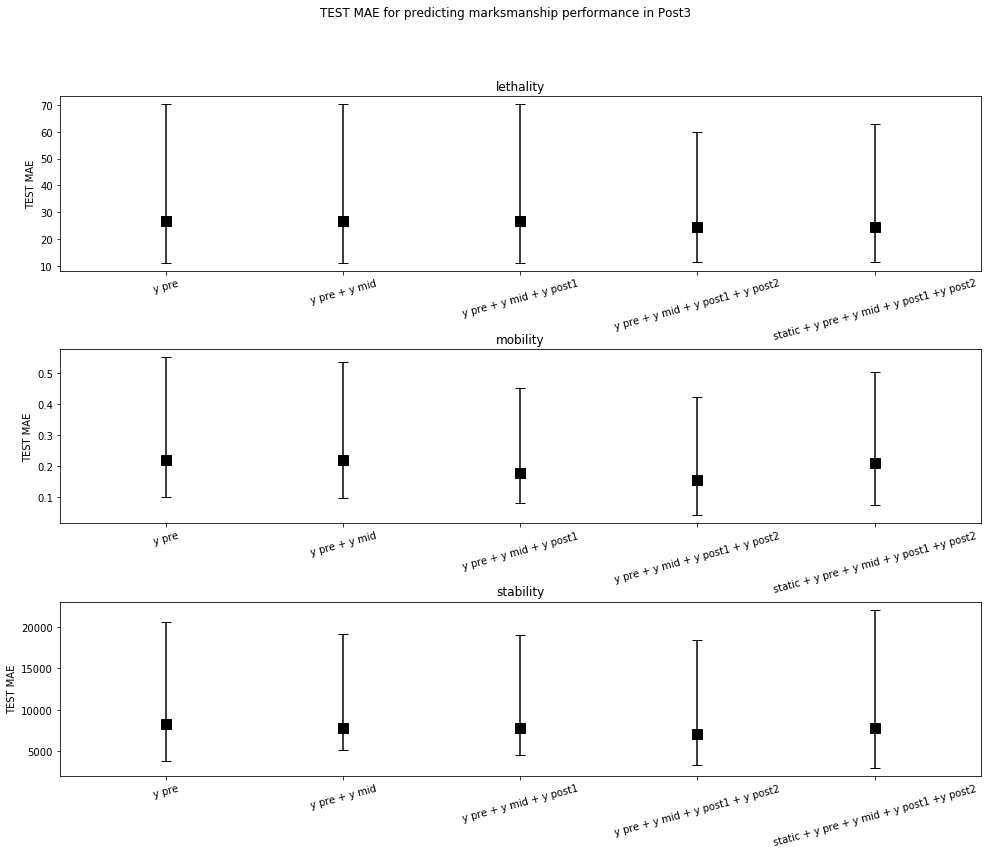

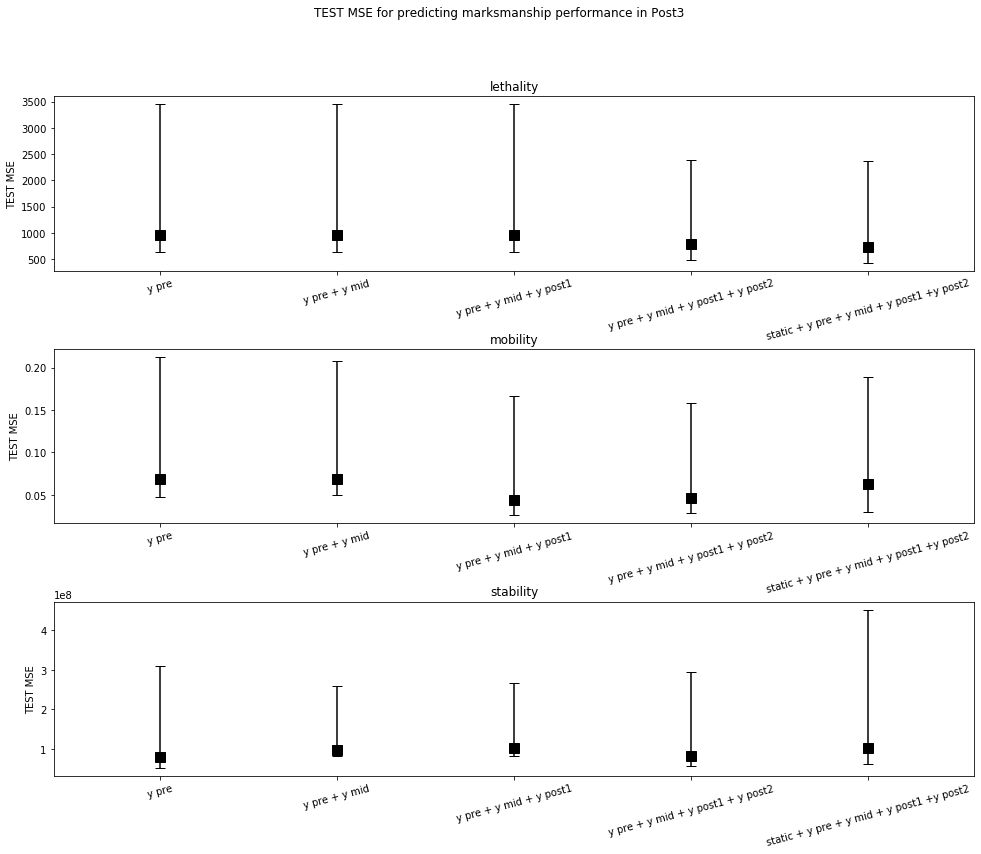

In [92]:
labels = ['y pre', 'y pre + y mid', 'y pre + y mid + y post1', 'y pre + y mid + y post1 + y post2', 
          'static + y pre + y mid + y post1 +y post2']

for error in ['test_mae', 'test_mse']:
    f,axs = plt.subplots(3,1)
    for ax_idx, y_factor in enumerate(['lethality', 'mobility', 'stability']):
    #     y_perf_df = summary_perf_df.loc[summary_perf_df.y_column==y_factor, :].copy().reset_index(drop=True)
    #     sns.boxplot(x=y_perf_df['x_feature_nickname'], y=y_perf_df['test_mae'], ax=axs[ax_idx])
    #     axs[ax_idx].set_xlabel(y_perf_df['y_column'].unique()[0])
        x = np.asarray(range(len(labels)))/2
        y = np.asarray(summary_perf_df.loc[(summary_perf_df.y_column==y_factor)&
                                (summary_perf_df.percentile_across_trials==50), error])

        y_err_l = np.asarray(summary_perf_df.loc[(summary_perf_df.y_column==y_factor)&
                                (summary_perf_df.percentile_across_trials==5), error])

        y_err_u = np.asarray(summary_perf_df.loc[(summary_perf_df.y_column==y_factor)&
                                (summary_perf_df.percentile_across_trials==95), error])
        y_err = np.concatenate((y_err_l.reshape(-1,1), y_err_u.reshape(-1,1)), axis=1).T

        axs[ax_idx].errorbar(x=x, y=y, yerr=y_err, color="black", capsize=5,
                             linestyle="None",marker="s", markersize=10, 
                             mfc="black", mec="black")
        axs[ax_idx].set_xlim([-.3,2.3])
        axs[ax_idx].set_xticks(x)
        axs[ax_idx].set_xticklabels(labels, rotation=15)
        axs[ax_idx].set_title(y_factor)
        err_aka = error.replace('_', ' ').upper()
        axs[ax_idx].set_ylabel(err_aka)
    
        plt.suptitle('%s for predicting marksmanship performance in Post3'%err_aka)
        plt.subplots_adjust(hspace=0.45)
        f.set_size_inches(16.5, 12.5)
        f.savefig('%s.png'%error)
plt.show()

In [67]:
summary_perf_df.x_feature_nickname.unique()

array(['pre', 'pre+mid', 'pre+mid+post1', 'pre+mid+post1+post2',
       'static+pre+mid+post1+post2', 'highfreq+pre+mid+post1+post2'],
      dtype=object)

In [12]:
    y = np.asarray(summary_perf_df.loc[(summary_perf_df.y_column==y_factor)&
                            (summary_perf_df.percentile_across_trials==50), 'test_mae'])
    
    y_err_l = np.asarray(summary_perf_df.loc[(summary_perf_df.y_column==y_factor)&
                            (summary_perf_df.percentile_across_trials==5), 'test_mae'])
    
    y_err_u = np.asarray(summary_perf_df.loc[(summary_perf_df.y_column==y_factor)&
                            (summary_perf_df.percentile_across_trials==95), 'test_mae'])

In [17]:
np.concatenate((y_err_l.reshape(-1,1), y_err_u.reshape(-1,1)), axis=1).shape

(4, 2)

In [90]:
summary_perf_df

,y_column,x_feature_nickname,n_features,percentile_across_trials,train_mse,test_mse,train_mae,test_mae,train_size,test_size,...,inner_split8_test_score,inner_split9_train_score,inner_split9_test_score,inner_min_train_score,inner_min_test_score,inner_max_train_score,inner_max_test_score,outer_model_bias,outer_model_num_nonzero_coef,outer_model_best_param__regressor__alpha
0,lethality,pre,1,5,1.321108e+03,3.186857e+02,27.817846,15.618902,40.0,5.0,...,17.802198,27.135841,17.370902,25.606434,8.697593,29.498447,43.147337,140.851809,0.00,9.658114e+00
1,lethality,pre,1,50,1.515085e+03,9.543238e+02,30.392921,26.740795,40.0,5.0,...,26.810196,29.369544,34.314622,27.094981,13.398828,32.664739,49.700740,143.069514,0.00,1.000000e+01
2,lethality,pre,1,95,1.593467e+03,2.495162e+03,31.974804,43.549713,40.0,5.0,...,36.590243,32.295786,46.872643,29.933038,21.081992,33.971182,70.306873,144.663852,0.00,3.162278e+01
3,lethality,pre+mid,2,5,1.321108e+03,3.186857e+02,27.817846,15.618902,40.0,5.0,...,17.802198,27.135841,17.370902,25.606434,8.697593,29.498447,43.147337,140.851809,0.00,1.000000e+01
4,lethality,pre+mid,2,50,1.515085e+03,9.543238e+02,30.392921,26.740795,40.0,5.0,...,26.810196,29.369544,34.314622,27.094981,13.398828,32.664739,49.700740,143.069514,0.00,1.000000e+01
5,lethality,pre+mid,2,95,1.593467e+03,2.495162e+03,31.974804,43.549713,40.0,5.0,...,36.590243,32.295786,46.872643,29.933038,21.081992,33.971182,70.306873,144.663852,0.00,3.162278e+01
6,lethality,pre+mid+post1,3,5,1.321108e+03,3.186857e+02,27.817846,15.618902,40.0,5.0,...,17.802198,27.135841,17.370902,25.606434,8.697593,29.498447,43.147337,140.851809,0.00,1.000000e+01
7,lethality,pre+mid+post1,3,50,1.515085e+03,9.543238e+02,30.392921,26.740795,40.0,5.0,...,26.810196,29.369544,34.314622,27.094981,13.398828,32.664739,49.700740,143.069514,0.00,3.162278e+01
8,lethality,pre+mid+post1,3,95,1.593467e+03,2.495162e+03,31.974804,43.549713,40.0,5.0,...,36.590243,32.295786,46.872643,29.933038,21.081992,33.971182,70.306873,144.663852,0.00,3.162278e+01
9,lethality,pre+mid+post1+post2,4,5,8.733777e+02,3.077968e+02,23.481576,13.034234,40.0,5.0,...,13.166815,22.749606,17.436443,20.896122,6.485544,24.555785,34.350546,140.851809,1.00,3.162278e+00


In [84]:
summary_perf_df.columns

Index(['y_column', 'x_feature_nickname', 'n_features',
       'percentile_across_trials', 'train_mse', 'test_mse', 'train_mae',
       'test_mae', 'train_size', 'test_size', 'outer_train_score',
       'outer_test_score', 'inner_mean_train_score', 'inner_mean_test_score',
       'inner_split0_train_score', 'inner_split0_test_score',
       'inner_split1_train_score', 'inner_split1_test_score',
       'inner_split2_train_score', 'inner_split2_test_score',
       'inner_min_train_score', 'inner_min_test_score',
       'inner_max_train_score', 'inner_max_test_score', 'outer_model_bias',
       'outer_model_num_nonzero_coef',
       'outer_model_best_param__regressor__alpha'],
      dtype='object')

In [85]:
np.logspace(-5, 5, 5)

array([1.00000000e-05, 3.16227766e-03, 1.00000000e+00, 3.16227766e+02,
       1.00000000e+05])